In [1]:
from DeltaT import DeltaT, DeltaT_with_error_estimate
import matplotlib.pyplot as plt 
import pandas as pd

## Examples of Delta T calculation with error estimate

In [2]:
DeltaT_with_error_estimate(2018.7)

'69.15 ± 0.05 seconds'

In [3]:
# Comparison with the second table in http://astro.ukho.gov.uk/nao/lvm/
y = range(-700, 1700, 100)
dT = lambda y1: [y1, DeltaT_with_error_estimate(y1)]
df = pd.DataFrame(list(map(dT,y)), columns=['y', 'DeltaT'])
print(df)

       y               DeltaT
0   -700  20050 ± 170 seconds
1   -600  18468 ± 160 seconds
2   -500  16940 ± 150 seconds
3   -400  15474 ± 130 seconds
4   -300  14081 ± 120 seconds
5   -200  12773 ± 110 seconds
6   -100  11558 ± 100 seconds
7      0   10441 ± 90 seconds
8    100    9405 ± 80 seconds
9    200    8425 ± 70 seconds
10   300    7476 ± 60 seconds
11   400    6535 ± 50 seconds
12   500    5587 ± 40 seconds
13   600    4652 ± 40 seconds
14   700    3760 ± 30 seconds
15   800    2943 ± 25 seconds
16   900    2230 ± 20 seconds
17  1000    1650 ± 15 seconds
18  1100    1223 ± 15 seconds
19  1200     915 ± 15 seconds
20  1300     681 ± 15 seconds
21  1400     482 ± 15 seconds
22  1500     292 ± 15 seconds
23  1600     109 ± 15 seconds


In [4]:
# Comparison with the 4th table in http://astro.ukho.gov.uk/nao/lvm/
y = range(1800, 1901, 10)
df = pd.DataFrame(list(map(dT,y)), columns=['y', 'DeltaT'])
print(df)

       y                DeltaT
0   1800    18.4 ± 0.5 seconds
1   1810    15.7 ± 0.2 seconds
2   1820    16.5 ± 0.2 seconds
3   1830    10.8 ± 0.2 seconds
4   1840     7.6 ± 0.1 seconds
5   1850     9.3 ± 0.1 seconds
6   1860     9.0 ± 0.1 seconds
7   1870   2.37 ± 0.05 seconds
8   1880  -3.21 ± 0.05 seconds
9   1890  -3.88 ± 0.05 seconds
10  1900  -1.98 ± 0.05 seconds


## Delta T Plot

Plot Delta T from y=1500 to y=2200

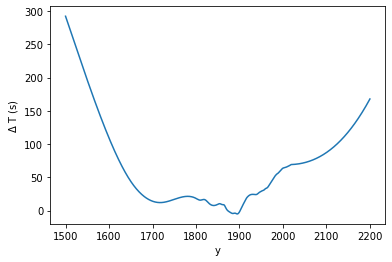

In [5]:
y = range(1500,2201)
dT = list(map(DeltaT, y))
plt.plot(y, dT)
plt.xlabel("y")
plt.ylabel(r"$\Delta$ T (s)")
plt.show()

## Error of the extrapolation formula for 2019 < y < 2022

Daily values of Delta T in 1972 and later can be constructed from the data published in [IERS Bulletin B](https://www.iers.org/IERS/EN/Publications/Bulletins/bulletins.html). 

The csv file "DeltaT_IERS.csv" contains data of Delta T from Jan 1972 to Jan 1, 2022 compiled from the IERS files. It has the following columns:
- year, month, day: UT1 date
- MJD: UT1 Julian date number - 2400000.5
- UT1_UTC: Value of UT1 - UTC in sec
- sigma: estimated error of UT1 in sec
- DeltaT: Delta T computed from (TT - UTC) - (UT1 - UTC) 
           = 42.184s + (accumulated leap seconds) - (UT1 - UTC)

The data in this csv file can be used to calculate the error of the extrapolation formula for Delta T for y from 2019 to Jan 1, 2022.

Value of y may be obtained from MJD using the fact that the MJD of 2000-Jan-1 0h is 51544 and there are 365.2425 days in a Gregorian year on average:
y = (MJD - 51544)/365.2425 + 2000

In [6]:
df = pd.read_csv("DeltaT_IERS.csv")

In [7]:
df['y'] = df.apply(lambda row: (row['MJD'] - 51544)/365.2425 + 2000, axis=1)

In [8]:
df = df[df.y > 2019]

In [9]:
df['eps'] = df.apply(lambda row: DeltaT(row['y']) - row['DeltaT'], axis=1)

In [10]:
df[['y','eps']].describe()

,y,eps
count,1097.000000,1097.000000
mean,2020.501448,-0.065351
std,0.867426,0.051774
min,2019.001075,-0.161724
25%,2019.751261,-0.097485
50%,2020.501448,-0.069496
75%,2021.251634,-0.047731
max,2022.001821,0.039021


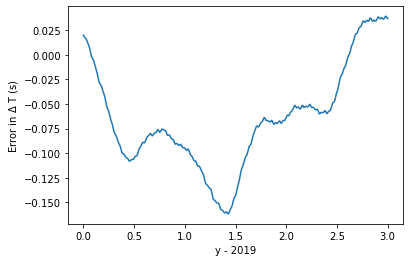

In [11]:
plt.plot(df['y'] - 2019, df['eps'])
plt.xlabel("y - 2019")
plt.ylabel(r"Error in $\Delta$ T (s)")
plt.show()

We see that for 2019 < y < 2022, the maximum error of the extrapolated Delta T is 0.16 seconds, the mean is -0.065 seconds and std is 0.052 seconds. The root-mean-square error is sqrt(0.065^2+0.052^2) = 0.083 seconds. This result has been incorporated in the function `DeltaT_error_estimate()` in `DeltaT.py`, where an error of 0.1s is used for 2019 < y < 2022.